In [2]:
import pandas as pd
import requests
import gzip
import io
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Function to download and cread pd df of the json file
def read_gzipped_json_from_url(url):
    # Send a HTTP request to the URL
    response = requests.get(url)
    # Check if the request was successful
    if response.status_code == 200:
        # Use gzip to decompress the content
        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gz:
            # Read the JSON lines file and convert to a DataFrame
            df = pd.read_json(gz, lines=True)
        return df
    else:
        print(f"Failed to retrieve data: status code {response.status_code}")
        return None

In [4]:
# URL to the gzipped JSON file
url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Luxury_Beauty_5.json.gz'
url2 = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/AMAZON_FASHION.json.gz'
luxury_df = read_gzipped_json_from_url(url).reset_index(drop=True)
amazon_fashion_df = read_gzipped_json_from_url(url2).reset_index(drop=True)

In [5]:
fashion_df = amazon_fashion_df[['overall','reviewText']]
luxury_df = luxury_df[['overall','reviewText']]

In [6]:
fashion_df = fashion_df.dropna()
luxury_df = luxury_df.dropna()

In [7]:
number_each_rating = 10000
balanced_df = fashion_df.groupby('overall').head(number_each_rating)
balanced_counts = balanced_df['overall'].value_counts()
print(balanced_counts)

overall
5    10000
2    10000
4    10000
3    10000
1    10000
Name: count, dtype: int64


In [8]:
# Defining the target variable
y = balanced_df['overall']

# Split the data into training and testing sets
df_xtrain, df_xval, df_ytrain, df_yval = train_test_split(balanced_df, y, test_size=0.1, random_state=42, stratify=y)
df_xtrain = df_xtrain.reset_index(drop=True)
df_xval = df_xval.reset_index(drop=True)
df_ytrain = df_ytrain.reset_index(drop=True)
df_yval = df_yval.reset_index(drop=True)

In [9]:
y_test = luxury_df['overall']
x_test = luxury_df['reviewText']

In [10]:
#Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = vectorizer.fit_transform(df_xtrain['reviewText'])
X_val_tfidf = vectorizer.transform(df_xval['reviewText'])
X_test_tfidf = vectorizer.transform(x_test)


In [21]:
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train_tfidf, df_ytrain)

y_val_pred = svm_model.predict(X_val_tfidf)

accuracy = accuracy_score(df_yval, y_val_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.6714


Grid search

In [23]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf']
    }
svm_model = SVC() 

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train_tfidf, df_ytrain)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_svm_model = grid_search.best_estimator_
y_val_pred = best_svm_model.predict(X_val_tfidf)

accuracy = accuracy_score(df_yval, y_val_pred)
print("Validation Accuracy:", accuracy)

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Validation Accuracy: 0.6928


In [26]:
y_test_pred = best_svm_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.39168247482854224


Train final model

In [11]:
svm_model_final = SVC(kernel='rbf', C=10)
svm_model_final.fit(X_train_tfidf, df_ytrain)

y_val_pred = svm_model_final.predict(X_val_tfidf)

accuracy = accuracy_score(df_yval, y_val_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.6928


Test on test data

In [14]:
y_test_pred = svm_model_final.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.39168247482854224


Confusion matrix

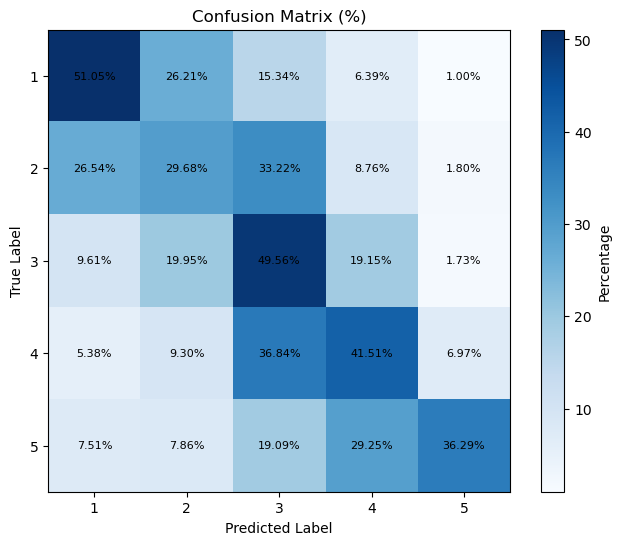

In [18]:
cm = confusion_matrix(y_test, y_test_pred)

cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
plt.colorbar(label='Percentage')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (%)")

for i in range(len(cm_percent)):
    for j in range(len(cm_percent[i])):
        plt.text(j, i, f'{cm_percent[i, j]:.2f}%', ha='center', va='center', color='black', fontsize=8)

plt.xticks(range(5), labels=range(1, 6))
plt.yticks(range(5), labels=range(1, 6))

plt.show()